## Bike Sharing Demand Prediction with Machine Learning Approaches

***This project was a group project, but I have only included the parts I have worked on***

- **Aim**: 
    - Take a look into the usage of bike sharing to identify any patterns and use different algorithms to build models to predict the demand of bike sharing. 
    - Find out the best performing model for the prediction of bike sharing demand using empirical datasets.

- **Dataset**: 
    - from Kaggle.com: Bike Sharing in Washington D.C. Dataset.
    - Link: ​https://www.kaggle.com/marklvl/bike-sharing-dataset
    - The two sets of data (day.csv and hour.csv) contain the daily and hourly count of rental bikes from 2011 to 2012 in the Capital Bikeshare System in Washington D.C. and other corresponding information such as weather and season. 
    - The hour dataset is used for the prediction analysis.
    
- **Model used**: 
    - Random Forest Regression
    - Gradient Boosting Regression Tree
    - K nearest neighnors(K=5)


### 1. Data Preprocessing

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

In [3]:
hour_df = pd.read_csv('hour.csv',sep=',')

In [22]:
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
rec_id               17379 non-null int64
datetime             17379 non-null datetime64[ns]
season               17379 non-null category
year                 17379 non-null category
month                17379 non-null category
hour                 17379 non-null category
is_holiday           17379 non-null category
weekday              17379 non-null category
is_workingday        17379 non-null category
weather_condition    17379 non-null category
temp                 17379 non-null float64
atemp                17379 non-null float64
humidity             17379 non-null float64
windspeed            17379 non-null float64
casual               17379 non-null int64
registered           17379 non-null int64
total_count          17379 non-null int64
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)
memory usage: 1.3 MB


**- We can see that there are no null values from above**

In [5]:
# Renaming columns names to more readable names
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [6]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

In [7]:
# Defining categorical variables encoder method
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [8]:
# Divide the dataset into training and testing sets
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],
                                        hour_df.iloc[:,-1],
                                        test_size=0.3,
                                        random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [9]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed',
                        'hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [10]:
#Econde training
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

Train dataset shape::(12165, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.50      0.42     0.1940    2       3     4    1       0.0       1.0   
1  0.68      0.79     0.1642   12       1     9    0       0.0       0.0   
2  0.34      0.36     0.4179    0       3     4    1       0.0       1.0   
3  0.70      0.34     0.0000   15       0     6    1       0.0       1.0   
4  0.56      0.52     0.2985   10       3    10    1       0.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       0.0       0.0           1.0           0.0                  0.0   
1       0.0       1.0           1.0           0.0                  0.0   
2       0.0       0.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       1.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4 

/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "cate

In [11]:
# Test dataset

test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Test dataset shape::(5214, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.80      0.27     0.1940   19       6     6    1       0.0       0.0   
1  0.24      0.41     0.2239   20       1     1    1       1.0       0.0   
2  0.32      0.66     0.2836    2       5    10    0       0.0       0.0   
3  0.78      0.52     0.3582   19       2     5    1       0.0       1.0   
4  0.26      0.56     0.3881    0       4     1    0       1.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       1.0       0.0           1.0           0.0                  1.0   
1       0.0       0.0           0.0           1.0                  1.0   
2       0.0       1.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4  \

/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "cate

In [12]:
# Constructing train dataset
X = train_df_new
y= y.total_count.values.reshape(-1,1)

# Constructing test dataset
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
print(X.shape,y.shape)

(12165, 19) (12165, 1)


## 2. Anaysis 

### 2.1. GBRT

Gradient Boosted Regression Tree can help to improve the overall model prediction by training a weak model that maps features to the residual calculated. 

Then, the residual is inputted into the existing model. And by iterating on this process, it pushes the model towards the right target.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn.model_selection import GridSearchCV   #Perforing grid search

I conducted 5 fold cross validation to obtain the optimal parameters for the model. Using learning rate of 0.1, and number of trees of 90. 

I got a training RMSE of 11.92, test RMSE of 40.05. Also, training MAE of 7.58, and testing MAE of 23.89. 

Large test error compared to training error indicates that the model is overfitting.

In [25]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 20)]

param_grid = {'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [5,10,15,30,40,50,60,70,80,90],
              'n_estimators' : n_estimators
              }

est = GradientBoostingRegressor()
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid,  cv = 5, verbose=2).fit(X, y)

# best hyperparameter setting
gs_cv.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=10, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV] .. learning_rate=0.1, max_depth=5, n_estimators=10, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=10, total=   0.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=20, total=   0.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=20, total=   0.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=20, total=   0.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=20, total=   0.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=20, total=   0.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=30, total=   0.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=30, total=   0.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=30, total=   0.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=30, total=   0.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=30, total=   0.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=40, total=   0.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=40, total=   0.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=40, total=   0.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=40, total=   0.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=40, total=   0.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=50, total=   1.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=50, total=   0.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=50, total=   0.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=50, total=   1.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=50, total=   1.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=60, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=60, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=60, total=   1.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=60, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=60, total=   1.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=70, total=   1.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=70, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=70, total=   1.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=70, total=   1.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=70 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=70, total=   1.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=80, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=80, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=80, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=80, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=80 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=80, total=   1.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=90, total=   1.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=90, total=   1.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=90, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=90, total=   1.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=90 .................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .. learning_rate=0.1, max_depth=5, n_estimators=90, total=   1.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=5, n_estimators=100, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=5, n_estimators=100, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=5, n_estimators=100, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=5, n_estimators=100, total=   1.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=100 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=5, n_estimators=100, total=   1.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=10, total=   1.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=10, total=   1.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=10, total=   1.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=10, total=   1.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=10, total=   1.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=20, total=   2.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=20, total=   2.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=20, total=   2.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=20, total=   2.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=20, total=   2.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=30, total=   3.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=30, total=   3.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=30, total=   3.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=30, total=   3.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=30, total=   3.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=40, total=   4.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=40, total=   4.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=40, total=   4.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=40, total=   5.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=40, total=   6.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=50, total=   5.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=50, total=   5.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=50, total=   5.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=50, total=   9.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=50, total=  11.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=60, total=   6.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=60, total=   7.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=60, total=  11.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=60, total=   6.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=60, total=   9.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=70, total=   8.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=70, total=  15.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=70, total=  10.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=70, total=   7.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=70, total=  16.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=80, total=  36.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=80, total=  16.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=80, total=  18.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=80, total=  18.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=80, total=  19.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=90, total=  21.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=90, total=  19.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=90, total=  17.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=90, total=  18.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=10, n_estimators=90, total=  16.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, total=  16.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, total=  17.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, total=  19.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, total=  21.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, total=  15.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=10, total=   4.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=10, total=   9.2s
[CV] learning_rate=0.1, max_depth=15, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=10, total=  10.0s
[CV] learning_rate=0.1, max_depth=15, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=10, total=  11.2s
[CV] learning_rate=0.1, max_depth=15, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=10, total=   9.3s
[CV] learning_rate=0.1, max_depth=15, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=20, total=  20.6s
[CV] learning_rate=0.1, max_depth=15, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=20, total=  20.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=20, total=  14.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=20, total=  21.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=20, total=  16.0s
[CV] learning_rate=0.1, max_depth=15, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=30, total=  20.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=30, total=  33.2s
[CV] learning_rate=0.1, max_depth=15, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=30, total=  31.7s
[CV] learning_rate=0.1, max_depth=15, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=30, total=  27.3s
[CV] learning_rate=0.1, max_depth=15, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=30, total=  26.0s
[CV] learning_rate=0.1, max_depth=15, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=40, total=  40.1s
[CV] learning_rate=0.1, max_depth=15, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=40, total=  42.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=40, total=  55.8s
[CV] learning_rate=0.1, max_depth=15, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=40, total=  51.3s
[CV] learning_rate=0.1, max_depth=15, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=40, total= 1.1min
[CV] learning_rate=0.1, max_depth=15, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=50, total= 1.4min
[CV] learning_rate=0.1, max_depth=15, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=50, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=50, total=  50.8s
[CV] learning_rate=0.1, max_depth=15, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=50, total=  45.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=50, total=  44.6s
[CV] learning_rate=0.1, max_depth=15, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=60, total=  40.1s
[CV] learning_rate=0.1, max_depth=15, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=60, total=  48.6s
[CV] learning_rate=0.1, max_depth=15, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=60, total=  56.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=60, total=  35.8s
[CV] learning_rate=0.1, max_depth=15, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=60, total=  41.2s
[CV] learning_rate=0.1, max_depth=15, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=70, total=  51.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=70, total=  47.8s
[CV] learning_rate=0.1, max_depth=15, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=70, total=  52.3s
[CV] learning_rate=0.1, max_depth=15, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=70, total=  52.5s
[CV] learning_rate=0.1, max_depth=15, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=70, total=  50.7s
[CV] learning_rate=0.1, max_depth=15, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=80, total= 1.1min
[CV] learning_rate=0.1, max_depth=15, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=80, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=80, total= 1.0min
[CV] learning_rate=0.1, max_depth=15, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=80, total=  53.8s
[CV] learning_rate=0.1, max_depth=15, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=80, total=  56.9s
[CV] learning_rate=0.1, max_depth=15, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=90, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=90, total= 1.1min
[CV] learning_rate=0.1, max_depth=15, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=90, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=90, total= 1.2min
[CV] learning_rate=0.1, max_depth=15, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=15, n_estimators=90, total= 1.6min
[CV] learning_rate=0.1, max_depth=15, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=15, n_estimators=100, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=15, n_estimators=100, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=15, n_estimators=100, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=15, n_estimators=100, total= 1.3min
[CV] learning_rate=0.1, max_depth=15, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=15, n_estimators=100, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=10, total=   9.6s
[CV] learning_rate=0.1, max_depth=30, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=10, total=  12.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=10, total=  12.5s
[CV] learning_rate=0.1, max_depth=30, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=10, total=  10.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=10, total=  13.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=20, total=  22.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=20, total=  25.9s
[CV] learning_rate=0.1, max_depth=30, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=20, total=  23.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=20, total=  25.6s
[CV] learning_rate=0.1, max_depth=30, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=20, total=  27.1s
[CV] learning_rate=0.1, max_depth=30, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=30, total=  31.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=30, total=  33.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=30, total=  28.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=30, total=  31.8s
[CV] learning_rate=0.1, max_depth=30, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=30, total=  32.7s
[CV] learning_rate=0.1, max_depth=30, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=40, total=  45.5s
[CV] learning_rate=0.1, max_depth=30, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=40, total=  40.8s
[CV] learning_rate=0.1, max_depth=30, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=40, total=  40.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=40, total=  40.6s
[CV] learning_rate=0.1, max_depth=30, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=40, total=  40.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=50, total=  50.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=50, total=  50.3s
[CV] learning_rate=0.1, max_depth=30, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=50, total=  49.6s
[CV] learning_rate=0.1, max_depth=30, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=50, total=  50.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=50, total=  52.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=60, total=  59.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=60, total=  59.4s
[CV] learning_rate=0.1, max_depth=30, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=60, total=  58.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=60, total=  58.0s
[CV] learning_rate=0.1, max_depth=30, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=30, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=30, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=30, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=30, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=30, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=30, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=30, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=30, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=30, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=30, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=30, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=30, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=30, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=30, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=30, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=30, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=30, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=30, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=30, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=10, total=  10.6s
[CV] learning_rate=0.1, max_depth=40, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=10, total=   9.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=10, total=   9.7s
[CV] learning_rate=0.1, max_depth=40, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=10, total=  10.1s
[CV] learning_rate=0.1, max_depth=40, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=10, total=   9.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=20, total=  19.9s
[CV] learning_rate=0.1, max_depth=40, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=20, total=  20.0s
[CV] learning_rate=0.1, max_depth=40, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=20, total=  19.1s
[CV] learning_rate=0.1, max_depth=40, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=20, total=  20.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=20, total=  20.1s
[CV] learning_rate=0.1, max_depth=40, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=30, total=  29.7s
[CV] learning_rate=0.1, max_depth=40, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=30, total=  30.3s
[CV] learning_rate=0.1, max_depth=40, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=30, total=  29.0s
[CV] learning_rate=0.1, max_depth=40, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=30, total=  30.1s
[CV] learning_rate=0.1, max_depth=40, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=30, total=  29.6s
[CV] learning_rate=0.1, max_depth=40, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=40, total=  39.2s
[CV] learning_rate=0.1, max_depth=40, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=40, total=  39.9s
[CV] learning_rate=0.1, max_depth=40, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=40, total=  38.7s
[CV] learning_rate=0.1, max_depth=40, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=40, total=  39.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=40, total=  39.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=50, total=  48.7s
[CV] learning_rate=0.1, max_depth=40, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=50, total=  49.4s
[CV] learning_rate=0.1, max_depth=40, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=50, total=  48.6s
[CV] learning_rate=0.1, max_depth=40, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=50, total=  48.9s
[CV] learning_rate=0.1, max_depth=40, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=50, total=  52.2s
[CV] learning_rate=0.1, max_depth=40, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=60, total=  58.8s
[CV] learning_rate=0.1, max_depth=40, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=40, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=60, total=  57.5s
[CV] learning_rate=0.1, max_depth=40, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=60, total=  59.5s
[CV] learning_rate=0.1, max_depth=40, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=40, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=40, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=40, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=40, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=40, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=40, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=40, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=40, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=40, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=40, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=40, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=40, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=40, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=40, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=40, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=40, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=40, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=50, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=10, total=  10.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=10, total=  10.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=10, total=   9.7s
[CV] learning_rate=0.1, max_depth=50, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=10, total=  10.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=20, total=  20.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=20, total=  20.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=20, total=  19.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=20, total=  23.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=20, total=  20.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=30, total=  30.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=30, total=  30.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=30, total=  30.4s
[CV] learning_rate=0.1, max_depth=50, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=30, total=  29.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=30, total=  30.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=40, total=  39.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=40, total=  40.2s
[CV] learning_rate=0.1, max_depth=50, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=40, total=  40.0s
[CV] learning_rate=0.1, max_depth=50, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=40, total=  40.1s
[CV] learning_rate=0.1, max_depth=50, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=40, total=  39.5s
[CV] learning_rate=0.1, max_depth=50, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=50, total=  49.9s
[CV] learning_rate=0.1, max_depth=50, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=50, total=  55.0s
[CV] learning_rate=0.1, max_depth=50, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=50, total=  49.6s
[CV] learning_rate=0.1, max_depth=50, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=50, total=  49.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=50, total=  52.3s
[CV] learning_rate=0.1, max_depth=50, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=60, total=  59.8s
[CV] learning_rate=0.1, max_depth=50, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=50, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=60, total=  58.6s
[CV] learning_rate=0.1, max_depth=50, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=60, total=  59.6s
[CV] learning_rate=0.1, max_depth=50, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=50, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=50, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=50, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=50, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=50, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=50, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=50, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=50, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=50, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=50, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=50, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=50, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=90, total= 1.6min
[CV] learning_rate=0.1, max_depth=50, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=50, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=50, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=50, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=50, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, total= 1.7min
[CV] learning_rate=0.1, max_depth=50, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=50, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=50, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=60, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=10, total=  10.3s
[CV] learning_rate=0.1, max_depth=60, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=10, total=  10.5s
[CV] learning_rate=0.1, max_depth=60, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=60, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=10, total=  10.5s
[CV] learning_rate=0.1, max_depth=60, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=60, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=20, total=  21.4s
[CV] learning_rate=0.1, max_depth=60, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=20, total=  21.8s
[CV] learning_rate=0.1, max_depth=60, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=20, total=  20.3s
[CV] learning_rate=0.1, max_depth=60, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=20, total=  21.2s
[CV] learning_rate=0.1, max_depth=60, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=20, total=  21.1s
[CV] learning_rate=0.1, max_depth=60, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=30, total=  30.9s
[CV] learning_rate=0.1, max_depth=60, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=30, total=  31.3s
[CV] learning_rate=0.1, max_depth=60, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=30, total=  29.9s
[CV] learning_rate=0.1, max_depth=60, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=30, total=  30.4s
[CV] learning_rate=0.1, max_depth=60, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=30, total=  30.1s
[CV] learning_rate=0.1, max_depth=60, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=40, total=  40.3s
[CV] learning_rate=0.1, max_depth=60, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=40, total=  44.0s
[CV] learning_rate=0.1, max_depth=60, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=40, total=  39.8s
[CV] learning_rate=0.1, max_depth=60, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=40, total=  39.6s
[CV] learning_rate=0.1, max_depth=60, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=40, total=  39.7s
[CV] learning_rate=0.1, max_depth=60, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=50, total=  49.9s
[CV] learning_rate=0.1, max_depth=60, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=50, total=  49.7s
[CV] learning_rate=0.1, max_depth=60, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=50, total=  48.4s
[CV] learning_rate=0.1, max_depth=60, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=50, total=  50.6s
[CV] learning_rate=0.1, max_depth=60, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=50, total=  49.4s
[CV] learning_rate=0.1, max_depth=60, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=60, total=  59.4s
[CV] learning_rate=0.1, max_depth=60, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=60, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=60, total=  59.5s
[CV] learning_rate=0.1, max_depth=60, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=60, total= 1.1min
[CV] learning_rate=0.1, max_depth=60, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=60, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=60, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=60, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=60, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=60, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=60, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=60, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=60, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=60, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=60, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=60, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=60, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=60, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=60, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=60, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=60, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=60, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=60, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=60, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=60, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=70, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=70, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=10, total=  10.0s
[CV] learning_rate=0.1, max_depth=70, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=10, total=  11.7s
[CV] learning_rate=0.1, max_depth=70, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=10, total=  10.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=10, total=  10.6s
[CV] learning_rate=0.1, max_depth=70, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=20, total=  20.0s
[CV] learning_rate=0.1, max_depth=70, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=20, total=  20.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=20, total=  22.0s
[CV] learning_rate=0.1, max_depth=70, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=20, total=  21.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=20, total=  20.7s
[CV] learning_rate=0.1, max_depth=70, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=30, total=  30.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=30, total=  31.1s
[CV] learning_rate=0.1, max_depth=70, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=30, total=  29.4s
[CV] learning_rate=0.1, max_depth=70, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=30, total=  30.4s
[CV] learning_rate=0.1, max_depth=70, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=30, total=  31.8s
[CV] learning_rate=0.1, max_depth=70, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=40, total=  46.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=40, total=  41.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=40, total=  40.4s
[CV] learning_rate=0.1, max_depth=70, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=40, total=  41.5s
[CV] learning_rate=0.1, max_depth=70, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=40, total=  40.1s
[CV] learning_rate=0.1, max_depth=70, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=50, total=  50.3s
[CV] learning_rate=0.1, max_depth=70, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=50, total=  51.4s
[CV] learning_rate=0.1, max_depth=70, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=50, total=  50.9s
[CV] learning_rate=0.1, max_depth=70, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=50, total=  50.7s
[CV] learning_rate=0.1, max_depth=70, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=50, total=  49.8s
[CV] learning_rate=0.1, max_depth=70, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=70, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=70, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=70, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=70, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=70, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=70, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=70, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=70, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=70, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=70, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=70, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=70, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=70, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=70, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.1, max_depth=70, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=70, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=70, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=70, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=70, n_estimators=100, total= 1.7min
[CV] learning_rate=0.1, max_depth=70, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=70, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=70, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=70, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=70, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=70, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=80, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=10, total=  10.2s
[CV] learning_rate=0.1, max_depth=80, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=10, total=  10.2s
[CV] learning_rate=0.1, max_depth=80, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=10, total=   9.8s
[CV] learning_rate=0.1, max_depth=80, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=10, total=  10.3s
[CV] learning_rate=0.1, max_depth=80, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=80, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=20, total=  20.0s
[CV] learning_rate=0.1, max_depth=80, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=20, total=  20.9s
[CV] learning_rate=0.1, max_depth=80, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=20, total=  19.5s
[CV] learning_rate=0.1, max_depth=80, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=20, total=  20.0s
[CV] learning_rate=0.1, max_depth=80, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=20, total=  19.8s
[CV] learning_rate=0.1, max_depth=80, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=30, total=  29.8s
[CV] learning_rate=0.1, max_depth=80, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=30, total=  31.0s
[CV] learning_rate=0.1, max_depth=80, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=30, total=  29.3s
[CV] learning_rate=0.1, max_depth=80, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=30, total=  30.6s
[CV] learning_rate=0.1, max_depth=80, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=30, total=  31.3s
[CV] learning_rate=0.1, max_depth=80, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=40, total=  40.2s
[CV] learning_rate=0.1, max_depth=80, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=40, total=  40.1s
[CV] learning_rate=0.1, max_depth=80, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=40, total=  39.1s
[CV] learning_rate=0.1, max_depth=80, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=40, total=  40.5s
[CV] learning_rate=0.1, max_depth=80, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=40, total=  39.5s
[CV] learning_rate=0.1, max_depth=80, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=50, total=  49.2s
[CV] learning_rate=0.1, max_depth=80, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=50, total=  51.6s
[CV] learning_rate=0.1, max_depth=80, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=50, total=  48.7s
[CV] learning_rate=0.1, max_depth=80, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=50, total=  50.5s
[CV] learning_rate=0.1, max_depth=80, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=50, total=  50.1s
[CV] learning_rate=0.1, max_depth=80, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=80, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.1, max_depth=80, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=60, total=  58.8s
[CV] learning_rate=0.1, max_depth=80, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=60, total=  59.4s
[CV] learning_rate=0.1, max_depth=80, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=60, total=  59.4s
[CV] learning_rate=0.1, max_depth=80, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=80, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=80, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=80, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=80, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=80, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=80, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=80, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=80, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=80, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=80, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=80, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=80, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=80, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=80, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=80, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=80, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=80, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=80, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=80, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=80, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=80, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=80, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=80, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=80, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=80, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=90, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=10, total=  10.0s
[CV] learning_rate=0.1, max_depth=90, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=10, total=  10.0s
[CV] learning_rate=0.1, max_depth=90, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=10, total=  10.6s
[CV] learning_rate=0.1, max_depth=90, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=10, total=   9.9s
[CV] learning_rate=0.1, max_depth=90, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=10, total=  10.2s
[CV] learning_rate=0.1, max_depth=90, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=20, total=  19.6s
[CV] learning_rate=0.1, max_depth=90, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=20, total=  20.0s
[CV] learning_rate=0.1, max_depth=90, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=20, total=  20.2s
[CV] learning_rate=0.1, max_depth=90, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=20, total=  19.9s
[CV] learning_rate=0.1, max_depth=90, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=20, total=  20.7s
[CV] learning_rate=0.1, max_depth=90, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=30, total=  29.3s
[CV] learning_rate=0.1, max_depth=90, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=30, total=  29.7s
[CV] learning_rate=0.1, max_depth=90, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=30, total=  28.8s
[CV] learning_rate=0.1, max_depth=90, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=30, total=  34.8s
[CV] learning_rate=0.1, max_depth=90, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=30, total=  30.3s
[CV] learning_rate=0.1, max_depth=90, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=40, total=  39.8s
[CV] learning_rate=0.1, max_depth=90, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=40, total=  41.6s
[CV] learning_rate=0.1, max_depth=90, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=40, total=  38.6s
[CV] learning_rate=0.1, max_depth=90, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=40, total=  38.8s
[CV] learning_rate=0.1, max_depth=90, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=40, total=  39.7s
[CV] learning_rate=0.1, max_depth=90, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=50, total=  48.9s
[CV] learning_rate=0.1, max_depth=90, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=50, total=  50.1s
[CV] learning_rate=0.1, max_depth=90, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=50, total=  48.3s
[CV] learning_rate=0.1, max_depth=90, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=50, total=  48.5s
[CV] learning_rate=0.1, max_depth=90, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=50, total=  49.4s
[CV] learning_rate=0.1, max_depth=90, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=60, total=  58.1s
[CV] learning_rate=0.1, max_depth=90, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=60, total= 1.0min
[CV] learning_rate=0.1, max_depth=90, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=60, total=  58.0s
[CV] learning_rate=0.1, max_depth=90, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=60, total=  59.8s
[CV] learning_rate=0.1, max_depth=90, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=60, total=  59.5s
[CV] learning_rate=0.1, max_depth=90, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=90, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=90, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=90, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=70, total= 1.1min
[CV] learning_rate=0.1, max_depth=90, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=70, total= 1.2min
[CV] learning_rate=0.1, max_depth=90, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=90, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=90, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=90, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=90, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=80, total= 1.3min
[CV] learning_rate=0.1, max_depth=90, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=90, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=90, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=90, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=90, total= 1.5min
[CV] learning_rate=0.1, max_depth=90, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.1, max_depth=90, n_estimators=90, total= 1.4min
[CV] learning_rate=0.1, max_depth=90, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=90, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=90, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=90, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=90, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=90, n_estimators=100, total= 1.5min
[CV] learning_rate=0.1, max_depth=90, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=90, n_estimators=100, total= 1.6min
[CV] learning_rate=0.1, max_depth=90, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.1, max_depth=90, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=10, total=   0.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=20, total=   0.7s
[CV] learning_rate=0.05, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=20, total=   0.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=20, total=   0.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=20, total=   0.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=20, total=   0.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=30, total=   0.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=30, total=   0.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=30, total=   0.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=30, total=   0.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=30, total=   0.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=40, total=   1.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=40, total=   1.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=40, total=   1.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=40, total=   1.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=40, total=   1.1s
[CV] learning_rate=0.05, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=50, total=   1.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=50, total=   1.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=50, total=   1.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=50, total=   1.4s
[CV] learning_rate=0.05, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=50, total=   1.4s
[CV] learning_rate=0.05, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=60, total=   1.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=60, total=   1.7s
[CV] learning_rate=0.05, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=60, total=   1.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=60, total=   1.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=60, total=   1.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=70, total=   1.8s
[CV] learning_rate=0.05, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=70, total=   1.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=70, total=   1.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=70, total=   2.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=70, total=   1.9s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=80, total=   2.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=80, total=   2.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=80, total=   2.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=80, total=   2.0s
[CV] learning_rate=0.05, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=80, total=   2.2s
[CV] learning_rate=0.05, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=90, total=   2.4s
[CV] learning_rate=0.05, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=90, total=   2.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=90, total=   2.2s
[CV] learning_rate=0.05, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=90, total=   2.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.05, max_depth=5, n_estimators=90, total=   2.3s
[CV] learning_rate=0.05, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, total=   2.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, total=   2.6s
[CV] learning_rate=0.05, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, total=   2.4s
[CV] learning_rate=0.05, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, total=   2.5s
[CV] learning_rate=0.05, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, total=   2.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, total=   1.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, total=   1.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, total=   1.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, total=   1.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, total=   1.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=20, total=   3.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=20, total=   3.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=20, total=   3.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=20, total=   3.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=20, total=   3.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=30, total=   5.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=30, total=   4.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=30, total=   5.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=30, total=   5.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=30, total=   4.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=40, total=   6.7s
[CV] learning_rate=0.05, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=40, total=   6.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=40, total=   6.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=40, total=   6.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=40, total=   6.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=50, total=   9.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=50, total=   8.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=50, total=   8.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=50, total=   8.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=50, total=   8.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=60, total=   9.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=60, total=  10.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=60, total=   9.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=60, total=   9.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=60, total=   9.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=70, total=  10.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=70, total=  11.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=70, total=  10.9s
[CV] learning_rate=0.05, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=70, total=  11.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=70, total=  11.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=80, total=  12.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=80, total=  12.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=80, total=  13.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=80, total=  12.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=80, total=  12.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=90, total=  14.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=90, total=  14.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=90, total=  14.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=90, total=  14.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=90, total=  13.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, total=  16.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, total=  15.8s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, total=  15.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, total=  15.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=10, n_estimators=100, total=  15.4s
[CV] learning_rate=0.05, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=10, total=   6.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=10, total=   6.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=10, total=   6.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=10, total=   6.4s
[CV] learning_rate=0.05, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=10, total=   6.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=20, total=  12.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=20, total=  14.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=20, total=  12.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=20, total=  13.2s
[CV] learning_rate=0.05, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=20, total=  12.7s
[CV] learning_rate=0.05, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=30, total=  19.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=30, total=  19.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=30, total=  19.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=30, total=  20.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=30, total=  19.4s
[CV] learning_rate=0.05, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=40, total=  28.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=40, total=  27.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=40, total=  25.7s
[CV] learning_rate=0.05, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=40, total=  27.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=40, total=  25.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=50, total=  33.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=50, total=  33.4s
[CV] learning_rate=0.05, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=50, total=  33.7s
[CV] learning_rate=0.05, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=50, total=  33.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=50, total=  32.9s
[CV] learning_rate=0.05, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=60, total=  40.9s
[CV] learning_rate=0.05, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=60, total=  41.6s
[CV] learning_rate=0.05, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=60, total=  39.9s
[CV] learning_rate=0.05, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=60, total=  43.6s
[CV] learning_rate=0.05, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=60, total=  39.9s
[CV] learning_rate=0.05, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=70, total=  47.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=70, total=  48.7s
[CV] learning_rate=0.05, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=70, total=  46.8s
[CV] learning_rate=0.05, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=70, total=  47.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=70, total=  47.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=80, total=  54.6s
[CV] learning_rate=0.05, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=80, total=  55.5s
[CV] learning_rate=0.05, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=80, total=  54.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=80, total=  54.7s
[CV] learning_rate=0.05, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=80, total=  52.9s
[CV] learning_rate=0.05, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=90, total= 1.0min
[CV] learning_rate=0.05, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=90, total= 1.0min
[CV] learning_rate=0.05, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=90, total= 1.0min
[CV] learning_rate=0.05, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=90, total=  60.0s
[CV] learning_rate=0.05, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=90, total= 1.0min
[CV] learning_rate=0.05, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=100, total= 1.1min
[CV] learning_rate=0.05, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=100, total= 1.2min
[CV] learning_rate=0.05, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=100, total= 1.1min
[CV] learning_rate=0.05, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=100, total= 1.1min
[CV] learning_rate=0.05, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=15, n_estimators=100, total= 1.1min
[CV] learning_rate=0.05, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=10, total=  10.9s
[CV] learning_rate=0.05, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=10, total=  10.2s
[CV] learning_rate=0.05, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=10, total=   9.7s
[CV] learning_rate=0.05, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=10, total=  10.0s
[CV] learning_rate=0.05, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=10, total=   9.8s
[CV] learning_rate=0.05, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=20, total=  19.6s
[CV] learning_rate=0.05, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=20, total=  19.3s
[CV] learning_rate=0.05, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=20, total=  20.5s
[CV] learning_rate=0.05, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=30, total=  29.4s
[CV] learning_rate=0.05, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=30, total=  29.8s
[CV] learning_rate=0.05, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=30, total=  28.7s
[CV] learning_rate=0.05, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=30, total=  30.0s
[CV] learning_rate=0.05, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=30, total=  29.8s
[CV] learning_rate=0.05, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=40, total=  38.8s
[CV] learning_rate=0.05, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=40, total=  40.9s
[CV] learning_rate=0.05, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=40, total=  38.6s
[CV] learning_rate=0.05, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=40, total=  39.3s
[CV] learning_rate=0.05, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=40, total=  39.4s
[CV] learning_rate=0.05, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=50, total=  48.4s
[CV] learning_rate=0.05, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=50, total=  49.0s
[CV] learning_rate=0.05, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=50, total=  49.9s
[CV] learning_rate=0.05, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=50, total=  48.2s
[CV] learning_rate=0.05, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=50, total=  49.5s
[CV] learning_rate=0.05, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=60, total=  58.3s
[CV] learning_rate=0.05, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=60, total=  58.3s
[CV] learning_rate=0.05, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=60, total=  59.0s
[CV] learning_rate=0.05, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=30, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=10, total=  10.9s
[CV] learning_rate=0.05, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=10, total=  11.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=10, total=  10.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=10, total=  10.5s
[CV] learning_rate=0.05, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=10, total=  10.4s
[CV] learning_rate=0.05, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=20, total=  19.4s
[CV] learning_rate=0.05, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=20, total=  19.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=20, total=  19.0s
[CV] learning_rate=0.05, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=30, total=  29.9s
[CV] learning_rate=0.05, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=30, total=  29.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=30, total=  28.2s
[CV] learning_rate=0.05, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=30, total=  29.1s
[CV] learning_rate=0.05, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=30, total=  31.0s
[CV] learning_rate=0.05, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=40, total=  38.8s
[CV] learning_rate=0.05, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=40, total=  39.0s
[CV] learning_rate=0.05, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=40, total=  39.4s
[CV] learning_rate=0.05, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=40, total=  38.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=40, total=  38.5s
[CV] learning_rate=0.05, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=50, total=  49.1s
[CV] learning_rate=0.05, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=50, total=  49.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=50, total=  47.4s
[CV] learning_rate=0.05, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=50, total=  49.2s
[CV] learning_rate=0.05, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=50, total=  48.3s
[CV] learning_rate=0.05, max_depth=40, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=60, total=  58.8s
[CV] learning_rate=0.05, max_depth=40, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=60, total=  58.6s
[CV] learning_rate=0.05, max_depth=40, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=40, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=60, total=  58.4s
[CV] learning_rate=0.05, max_depth=40, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=60, total=  58.9s
[CV] learning_rate=0.05, max_depth=40, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=40, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=40, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=40, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=40, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=40, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=40, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=40, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=40, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=40, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=40, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=40, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=40, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=90, total= 1.4min
[CV] learning_rate=0.05, max_depth=40, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=40, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=40, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=40, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=40, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=40, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=40, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=40, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=50, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=10, total=  10.2s
[CV] learning_rate=0.05, max_depth=50, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=10, total=  10.1s
[CV] learning_rate=0.05, max_depth=50, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=10, total=   9.7s
[CV] learning_rate=0.05, max_depth=50, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=10, total=   9.9s
[CV] learning_rate=0.05, max_depth=50, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=10, total=   9.5s
[CV] learning_rate=0.05, max_depth=50, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=20, total=  19.2s
[CV] learning_rate=0.05, max_depth=50, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=20, total=  19.8s
[CV] learning_rate=0.05, max_depth=50, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=20, total=  20.1s
[CV] learning_rate=0.05, max_depth=50, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=20, total=  19.3s
[CV] learning_rate=0.05, max_depth=50, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=20, total=  19.4s
[CV] learning_rate=0.05, max_depth=50, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=30, total=  28.8s
[CV] learning_rate=0.05, max_depth=50, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=30, total=  29.4s
[CV] learning_rate=0.05, max_depth=50, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=30, total=  29.2s
[CV] learning_rate=0.05, max_depth=50, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=30, total=  29.2s
[CV] learning_rate=0.05, max_depth=50, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=30, total=  29.1s
[CV] learning_rate=0.05, max_depth=50, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=40, total=  38.6s
[CV] learning_rate=0.05, max_depth=50, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=40, total=  40.1s
[CV] learning_rate=0.05, max_depth=50, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=40, total=  38.0s
[CV] learning_rate=0.05, max_depth=50, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=40, total=  38.6s
[CV] learning_rate=0.05, max_depth=50, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=40, total=  39.5s
[CV] learning_rate=0.05, max_depth=50, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=50, total=  48.0s
[CV] learning_rate=0.05, max_depth=50, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=50, total=  52.7s
[CV] learning_rate=0.05, max_depth=50, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=50, total=  48.1s
[CV] learning_rate=0.05, max_depth=50, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=50, total=  48.7s
[CV] learning_rate=0.05, max_depth=50, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=50, total=  49.6s
[CV] learning_rate=0.05, max_depth=50, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=60, total=  58.4s
[CV] learning_rate=0.05, max_depth=50, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=50, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=50, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=60, total=  59.5s
[CV] learning_rate=0.05, max_depth=50, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=60, total=  59.0s
[CV] learning_rate=0.05, max_depth=50, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=50, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=50, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=50, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=50, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=50, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=50, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=50, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=50, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=50, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=50, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=50, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=50, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=90, total= 1.4min
[CV] learning_rate=0.05, max_depth=50, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=50, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=50, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=50, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=50, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=50, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=50, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=50, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=60, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=10, total=  10.8s
[CV] learning_rate=0.05, max_depth=60, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=10, total=  10.0s
[CV] learning_rate=0.05, max_depth=60, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=10, total=  10.7s
[CV] learning_rate=0.05, max_depth=60, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=10, total=   9.8s
[CV] learning_rate=0.05, max_depth=60, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=10, total=  10.1s
[CV] learning_rate=0.05, max_depth=60, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=60, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=20, total=  19.7s
[CV] learning_rate=0.05, max_depth=60, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=20, total=  19.1s
[CV] learning_rate=0.05, max_depth=60, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=20, total=  19.7s
[CV] learning_rate=0.05, max_depth=60, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=20, total=  20.5s
[CV] learning_rate=0.05, max_depth=60, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=30, total=  29.2s
[CV] learning_rate=0.05, max_depth=60, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=30, total=  29.8s
[CV] learning_rate=0.05, max_depth=60, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=30, total=  28.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=30, total=  32.4s
[CV] learning_rate=0.05, max_depth=60, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=30, total=  29.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=40, total=  39.5s
[CV] learning_rate=0.05, max_depth=60, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=40, total=  39.7s
[CV] learning_rate=0.05, max_depth=60, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=40, total=  39.5s
[CV] learning_rate=0.05, max_depth=60, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=40, total=  39.4s
[CV] learning_rate=0.05, max_depth=60, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=40, total=  40.0s
[CV] learning_rate=0.05, max_depth=60, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=50, total=  49.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=50, total=  49.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=50, total=  49.3s
[CV] learning_rate=0.05, max_depth=60, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=50, total=  48.8s
[CV] learning_rate=0.05, max_depth=60, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=50, total=  49.2s
[CV] learning_rate=0.05, max_depth=60, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=60, total=  59.8s
[CV] learning_rate=0.05, max_depth=60, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=60, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=60, total=  58.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=60, total=  58.9s
[CV] learning_rate=0.05, max_depth=60, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=60, total= 1.0min
[CV] learning_rate=0.05, max_depth=60, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=60, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=60, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=60, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=60, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=60, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=60, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=60, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=60, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=60, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=60, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=60, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=60, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=60, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=60, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=90, total= 1.5min
[CV] learning_rate=0.05, max_depth=60, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=60, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=60, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=100, total= 1.6min
[CV] learning_rate=0.05, max_depth=60, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=60, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=60, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=70, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=10, total=   9.7s
[CV] learning_rate=0.05, max_depth=70, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=10, total=  12.0s
[CV] learning_rate=0.05, max_depth=70, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=10, total=   9.8s
[CV] learning_rate=0.05, max_depth=70, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=10, total=  10.8s
[CV] learning_rate=0.05, max_depth=70, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=10, total=  10.1s
[CV] learning_rate=0.05, max_depth=70, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=20, total=  19.5s
[CV] learning_rate=0.05, max_depth=70, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=20, total=  20.0s
[CV] learning_rate=0.05, max_depth=70, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=20, total=  19.4s
[CV] learning_rate=0.05, max_depth=70, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=20, total=  19.7s
[CV] learning_rate=0.05, max_depth=70, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=20, total=  19.7s
[CV] learning_rate=0.05, max_depth=70, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=30, total=  30.6s
[CV] learning_rate=0.05, max_depth=70, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=30, total=  30.1s
[CV] learning_rate=0.05, max_depth=70, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=30, total=  32.3s
[CV] learning_rate=0.05, max_depth=70, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=30, total=  29.6s
[CV] learning_rate=0.05, max_depth=70, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=30, total=  30.4s
[CV] learning_rate=0.05, max_depth=70, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=40, total=  40.1s
[CV] learning_rate=0.05, max_depth=70, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=40, total=  40.3s
[CV] learning_rate=0.05, max_depth=70, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=40, total=  39.6s
[CV] learning_rate=0.05, max_depth=70, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=40, total=  39.6s
[CV] learning_rate=0.05, max_depth=70, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=40, total=  40.7s
[CV] learning_rate=0.05, max_depth=70, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=50, total=  52.5s
[CV] learning_rate=0.05, max_depth=70, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=50, total=  47.4s
[CV] learning_rate=0.05, max_depth=70, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=50, total=  47.5s
[CV] learning_rate=0.05, max_depth=70, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=50, total=  46.9s
[CV] learning_rate=0.05, max_depth=70, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=50, total=  46.8s
[CV] learning_rate=0.05, max_depth=70, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=60, total=  57.6s
[CV] learning_rate=0.05, max_depth=70, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=70, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=60, total=  57.3s
[CV] learning_rate=0.05, max_depth=70, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=60, total=  57.9s
[CV] learning_rate=0.05, max_depth=70, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=60, total=  58.8s
[CV] learning_rate=0.05, max_depth=70, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=70, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=70, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=70, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=70, total= 1.1min
[CV] learning_rate=0.05, max_depth=70, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=70, total= 1.2min
[CV] learning_rate=0.05, max_depth=70, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=80, total= 1.3min
[CV] learning_rate=0.05, max_depth=70, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=70, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=70, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=70, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=80, total= 1.4min
[CV] learning_rate=0.05, max_depth=70, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=90, total= 1.6min
[CV] learning_rate=0.05, max_depth=70, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=90, total= 1.6min
[CV] learning_rate=0.05, max_depth=70, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=90, total= 1.8min
[CV] learning_rate=0.05, max_depth=70, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=90, total= 1.7min
[CV] learning_rate=0.05, max_depth=70, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=90, total= 1.6min
[CV] learning_rate=0.05, max_depth=70, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=100, total= 1.8min
[CV] learning_rate=0.05, max_depth=70, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=70, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=100, total= 1.7min
[CV] learning_rate=0.05, max_depth=70, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=100, total= 1.8min
[CV] learning_rate=0.05, max_depth=70, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=70, n_estimators=100, total= 1.8min
[CV] learning_rate=0.05, max_depth=80, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=10, total=   9.0s
[CV] learning_rate=0.05, max_depth=80, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=10, total=  11.0s
[CV] learning_rate=0.05, max_depth=80, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=10, total=  11.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=10, total=   8.2s
[CV] learning_rate=0.05, max_depth=80, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=10, total=  12.1s
[CV] learning_rate=0.05, max_depth=80, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=20, total=  21.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=20, total=  23.7s
[CV] learning_rate=0.05, max_depth=80, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=20, total=  19.1s
[CV] learning_rate=0.05, max_depth=80, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=20, total=  22.2s
[CV] learning_rate=0.05, max_depth=80, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=20, total=  19.8s
[CV] learning_rate=0.05, max_depth=80, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=30, total=  34.6s
[CV] learning_rate=0.05, max_depth=80, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=30, total=  31.2s
[CV] learning_rate=0.05, max_depth=80, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=30, total=  31.6s
[CV] learning_rate=0.05, max_depth=80, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=30, total=  30.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=30, total=  34.7s
[CV] learning_rate=0.05, max_depth=80, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=40, total=  40.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=40, total=  43.3s
[CV] learning_rate=0.05, max_depth=80, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=40, total=  46.5s
[CV] learning_rate=0.05, max_depth=80, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=40, total=  44.7s
[CV] learning_rate=0.05, max_depth=80, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=40, total=  41.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=50, total=  51.9s
[CV] learning_rate=0.05, max_depth=80, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=50, total=  55.8s
[CV] learning_rate=0.05, max_depth=80, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=50, total=  56.4s
[CV] learning_rate=0.05, max_depth=80, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=50, total=  50.8s
[CV] learning_rate=0.05, max_depth=80, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=50, total=  57.4s
[CV] learning_rate=0.05, max_depth=80, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=80, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=80, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=80, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=80, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=80, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=70, total= 1.3min
[CV] learning_rate=0.05, max_depth=80, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=70, total= 1.4min
[CV] learning_rate=0.05, max_depth=80, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=70, total= 1.3min
[CV] learning_rate=0.05, max_depth=80, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=70, total= 1.3min
[CV] learning_rate=0.05, max_depth=80, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=70, total= 1.3min
[CV] learning_rate=0.05, max_depth=80, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=80, total= 1.5min
[CV] learning_rate=0.05, max_depth=80, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=80, total= 1.5min
[CV] learning_rate=0.05, max_depth=80, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=80, total= 1.5min
[CV] learning_rate=0.05, max_depth=80, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=80, total= 1.5min
[CV] learning_rate=0.05, max_depth=80, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=80, total= 1.5min
[CV] learning_rate=0.05, max_depth=80, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=90, total= 1.7min
[CV] learning_rate=0.05, max_depth=80, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=90, total= 1.7min
[CV] learning_rate=0.05, max_depth=80, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=90, total= 1.4min
[CV] learning_rate=0.05, max_depth=80, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=90, total= 1.6min
[CV] learning_rate=0.05, max_depth=80, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=90, total= 1.6min
[CV] learning_rate=0.05, max_depth=80, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=80, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=80, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=80, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=80, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=80, n_estimators=100, total= 1.9min
[CV] learning_rate=0.05, max_depth=90, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=10, total=  11.2s
[CV] learning_rate=0.05, max_depth=90, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=10, total=  11.4s
[CV] learning_rate=0.05, max_depth=90, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=10, total=  12.4s
[CV] learning_rate=0.05, max_depth=90, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=10, total=  14.0s
[CV] learning_rate=0.05, max_depth=90, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=10, total=  11.4s
[CV] learning_rate=0.05, max_depth=90, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=20, total=  22.8s
[CV] learning_rate=0.05, max_depth=90, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=20, total=  23.1s
[CV] learning_rate=0.05, max_depth=90, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=20, total=  22.3s
[CV] learning_rate=0.05, max_depth=90, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=20, total=  22.7s
[CV] learning_rate=0.05, max_depth=90, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=20, total=  24.0s
[CV] learning_rate=0.05, max_depth=90, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=30, total=  34.1s
[CV] learning_rate=0.05, max_depth=90, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=30, total=  34.3s
[CV] learning_rate=0.05, max_depth=90, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=30, total=  57.4s
[CV] learning_rate=0.05, max_depth=90, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=30, total= 1.4min
[CV] learning_rate=0.05, max_depth=90, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=30, total=  54.8s
[CV] learning_rate=0.05, max_depth=90, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=40, total= 1.2min
[CV] learning_rate=0.05, max_depth=90, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=40, total= 1.1min
[CV] learning_rate=0.05, max_depth=90, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=40, total=  58.4s
[CV] learning_rate=0.05, max_depth=90, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=40, total=  49.8s
[CV] learning_rate=0.05, max_depth=90, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=40, total=  43.2s
[CV] learning_rate=0.05, max_depth=90, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=50, total=  55.5s
[CV] learning_rate=0.05, max_depth=90, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=50, total=  54.7s
[CV] learning_rate=0.05, max_depth=90, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=50, total=  47.6s
[CV] learning_rate=0.05, max_depth=90, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=50, total=  51.8s
[CV] learning_rate=0.05, max_depth=90, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=50, total=  55.1s
[CV] learning_rate=0.05, max_depth=90, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=90, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=60, total= 1.2min
[CV] learning_rate=0.05, max_depth=90, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=60, total= 1.1min
[CV] learning_rate=0.05, max_depth=90, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=60, total= 1.2min
[CV] learning_rate=0.05, max_depth=90, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=60, total= 1.2min
[CV] learning_rate=0.05, max_depth=90, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=70, total= 1.4min
[CV] learning_rate=0.05, max_depth=90, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=70, total= 1.5min
[CV] learning_rate=0.05, max_depth=90, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=70, total= 1.4min
[CV] learning_rate=0.05, max_depth=90, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=70, total= 1.4min
[CV] learning_rate=0.05, max_depth=90, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=70, total= 1.4min
[CV] learning_rate=0.05, max_depth=90, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=80, total= 1.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=80, total= 1.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=80, total= 1.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=80, total= 1.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=80, total= 1.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=90, total= 1.8min
[CV] learning_rate=0.05, max_depth=90, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=90, total= 1.9min
[CV] learning_rate=0.05, max_depth=90, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=90, total= 1.8min
[CV] learning_rate=0.05, max_depth=90, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=90, total= 1.8min
[CV] learning_rate=0.05, max_depth=90, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=90, total= 1.8min
[CV] learning_rate=0.05, max_depth=90, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=100, total= 4.0min
[CV] learning_rate=0.05, max_depth=90, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=100, total= 3.2min
[CV] learning_rate=0.05, max_depth=90, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=100, total= 3.6min
[CV] learning_rate=0.05, max_depth=90, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=100, total= 3.1min
[CV] learning_rate=0.05, max_depth=90, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.05, max_depth=90, n_estimators=100, total= 3.3min
[CV] learning_rate=0.01, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=10, total=   0.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=10, total=   0.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=10, total=   0.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=10, total=   0.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=10 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=10, total=   0.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=20, total=   1.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=20, total=   1.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=20, total=   0.8s
[CV] learning_rate=0.01, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=20, total=   0.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=20 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=20, total=   0.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=30, total=   0.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=30, total=   0.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=30, total=   0.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=30, total=   0.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=30 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=30, total=   0.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=40, total=   0.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=40, total=   1.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=40, total=   1.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=40, total=   1.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=40 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=40, total=   1.3s
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=50, total=   1.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=50, total=   1.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=50, total=   1.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=50, total=   1.8s
[CV] learning_rate=0.01, max_depth=5, n_estimators=50 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=50, total=   1.8s
[CV] learning_rate=0.01, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=60, total=   1.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=60, total=   2.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=60, total=   1.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=60, total=   1.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=60 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=60, total=   2.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=70, total=   2.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=70, total=   2.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=70, total=   2.3s
[CV] learning_rate=0.01, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=70, total=   2.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=70 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=70, total=   2.3s
[CV] learning_rate=0.01, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=80, total=   2.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=80, total=   3.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=80, total=   3.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=80, total=   2.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=80 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=80, total=   2.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=90, total=   2.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=90, total=   3.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=90, total=   3.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=90, total=   3.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=90 ................


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] . learning_rate=0.01, max_depth=5, n_estimators=90, total=   3.0s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, total=   3.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, total=   3.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, total=   3.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, total=   3.2s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, total=   3.1s
[CV] learning_rate=0.01, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=10, total=   2.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=10, total=   2.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=10, total=   2.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=10, total=   2.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=10, total=   2.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=20, total=   4.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=20, total=   4.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=20, total=   4.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=20, total=   4.1s
[CV] learning_rate=0.01, max_depth=10, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=20, total=   4.1s
[CV] learning_rate=0.01, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=30, total=   6.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=30, total=   6.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=30, total=   6.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=30, total=   6.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=30, total=   6.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=40, total=   8.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=40, total=   9.6s
[CV] learning_rate=0.01, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=40, total=   9.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=40, total=   8.6s
[CV] learning_rate=0.01, max_depth=10, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=40, total=   8.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, total=  10.7s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, total=  10.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, total=  10.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, total=  10.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, total=  10.6s
[CV] learning_rate=0.01, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=60, total=  12.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=60, total=  12.9s
[CV] learning_rate=0.01, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=60, total=  15.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=60, total=  14.4s
[CV] learning_rate=0.01, max_depth=10, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=60, total=  14.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=70, total=  16.4s
[CV] learning_rate=0.01, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=70, total=  15.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=70, total=  14.9s
[CV] learning_rate=0.01, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=70, total=  15.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=70, total=  15.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=80, total=  20.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=80, total=  17.5s
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=80, total=  17.6s
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=80, total=  17.1s
[CV] learning_rate=0.01, max_depth=10, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=80, total=  16.9s
[CV] learning_rate=0.01, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=90, total=  19.6s
[CV] learning_rate=0.01, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=90, total=  19.4s
[CV] learning_rate=0.01, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=90, total=  21.1s
[CV] learning_rate=0.01, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=90, total=  19.9s
[CV] learning_rate=0.01, max_depth=10, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=90, total=  20.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, total=  26.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, total=  21.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, total=  23.4s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, total=  21.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, total=  21.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, total=   9.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, total=   8.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, total=   8.3s
[CV] learning_rate=0.01, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, total=   8.2s
[CV] learning_rate=0.01, max_depth=15, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, total=   8.2s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, total=  16.8s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, total=  18.4s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, total=  16.3s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, total=  16.7s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, total=  16.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=30, total=  27.5s
[CV] learning_rate=0.01, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=30, total=  25.7s
[CV] learning_rate=0.01, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=30, total=  26.0s
[CV] learning_rate=0.01, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=30, total=  30.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=30, total=  25.7s
[CV] learning_rate=0.01, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=40, total=  33.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=40, total=  38.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=40, total=  33.2s
[CV] learning_rate=0.01, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=40, total=  33.7s
[CV] learning_rate=0.01, max_depth=15, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=40, total=  35.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=50, total=  42.3s
[CV] learning_rate=0.01, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=50, total=  44.8s
[CV] learning_rate=0.01, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=50, total=  43.2s
[CV] learning_rate=0.01, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=50, total=  43.4s
[CV] learning_rate=0.01, max_depth=15, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=50, total=  42.1s
[CV] learning_rate=0.01, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=60, total=  55.4s
[CV] learning_rate=0.01, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=60, total=  52.9s
[CV] learning_rate=0.01, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=60, total=  52.3s
[CV] learning_rate=0.01, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=60, total=  50.8s
[CV] learning_rate=0.01, max_depth=15, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=60, total=  52.8s
[CV] learning_rate=0.01, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=70, total= 1.0min
[CV] learning_rate=0.01, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=70, total= 1.0min
[CV] learning_rate=0.01, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=70, total= 1.1min
[CV] learning_rate=0.01, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=70, total= 1.0min
[CV] learning_rate=0.01, max_depth=15, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=70, total= 1.0min
[CV] learning_rate=0.01, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=80, total= 1.2min
[CV] learning_rate=0.01, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=80, total= 1.2min
[CV] learning_rate=0.01, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=80, total= 1.2min
[CV] learning_rate=0.01, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=80, total= 1.2min
[CV] learning_rate=0.01, max_depth=15, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=80, total= 1.1min
[CV] learning_rate=0.01, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=90, total= 1.3min
[CV] learning_rate=0.01, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=90, total= 1.4min
[CV] learning_rate=0.01, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=90, total= 1.3min
[CV] learning_rate=0.01, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=90, total= 1.3min
[CV] learning_rate=0.01, max_depth=15, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=90, total= 1.3min
[CV] learning_rate=0.01, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=100, total= 1.5min
[CV] learning_rate=0.01, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=100, total= 1.6min
[CV] learning_rate=0.01, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=100, total= 1.5min
[CV] learning_rate=0.01, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=100, total= 1.5min
[CV] learning_rate=0.01, max_depth=15, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=15, n_estimators=100, total= 1.4min
[CV] learning_rate=0.01, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=10, total=  14.1s
[CV] learning_rate=0.01, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=10, total=  14.4s
[CV] learning_rate=0.01, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=10, total=  14.5s
[CV] learning_rate=0.01, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=10, total=  14.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=10, total=  12.8s
[CV] learning_rate=0.01, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=20, total=  27.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=20, total=  26.5s
[CV] learning_rate=0.01, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=20, total=  28.7s
[CV] learning_rate=0.01, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=20, total=  27.3s
[CV] learning_rate=0.01, max_depth=30, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=20, total=  26.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=30, total=  39.3s
[CV] learning_rate=0.01, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=30, total=  43.9s
[CV] learning_rate=0.01, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=30, total=  38.7s
[CV] learning_rate=0.01, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=30, total=  39.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=30, total=  40.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=40, total=  54.3s
[CV] learning_rate=0.01, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=40, total=  54.2s
[CV] learning_rate=0.01, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=40, total=  51.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=40, total=  52.0s
[CV] learning_rate=0.01, max_depth=30, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=40, total=  55.6s
[CV] learning_rate=0.01, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=50, total= 1.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=50, total= 1.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=50, total= 1.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=50, total= 1.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=50, total= 1.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=60, total= 1.3min
[CV] learning_rate=0.01, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=60, total= 1.4min
[CV] learning_rate=0.01, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=60, total= 1.3min
[CV] learning_rate=0.01, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=60, total= 1.3min
[CV] learning_rate=0.01, max_depth=30, n_estimators=60 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=60, total= 1.3min
[CV] learning_rate=0.01, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=70, total= 1.6min
[CV] learning_rate=0.01, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=70, total= 1.7min
[CV] learning_rate=0.01, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=70, total= 1.5min
[CV] learning_rate=0.01, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=70, total= 1.6min
[CV] learning_rate=0.01, max_depth=30, n_estimators=70 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=70, total= 1.6min
[CV] learning_rate=0.01, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=80, total= 1.8min
[CV] learning_rate=0.01, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=80, total= 2.6min
[CV] learning_rate=0.01, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=80, total= 2.2min
[CV] learning_rate=0.01, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=80, total= 2.1min
[CV] learning_rate=0.01, max_depth=30, n_estimators=80 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=80, total= 1.5min
[CV] learning_rate=0.01, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=90, total= 1.7min
[CV] learning_rate=0.01, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=90, total= 1.8min
[CV] learning_rate=0.01, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=90, total= 1.7min
[CV] learning_rate=0.01, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=90, total= 1.8min
[CV] learning_rate=0.01, max_depth=30, n_estimators=90 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=90, total= 1.8min
[CV] learning_rate=0.01, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=100, total= 2.0min
[CV] learning_rate=0.01, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=100, total= 2.3min
[CV] learning_rate=0.01, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=100, total= 1.6min
[CV] learning_rate=0.01, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=100, total= 1.7min
[CV] learning_rate=0.01, max_depth=30, n_estimators=100 ..............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=30, n_estimators=100, total= 1.7min
[CV] learning_rate=0.01, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=10, total=  11.0s
[CV] learning_rate=0.01, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=10, total=  10.3s
[CV] learning_rate=0.01, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=10, total=   9.3s
[CV] learning_rate=0.01, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=10, total=  10.5s
[CV] learning_rate=0.01, max_depth=40, n_estimators=10 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=10, total=  10.7s
[CV] learning_rate=0.01, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=20, total=  21.8s
[CV] learning_rate=0.01, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=20, total=  18.6s
[CV] learning_rate=0.01, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=20, total=  22.2s
[CV] learning_rate=0.01, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=20, total=  18.4s
[CV] learning_rate=0.01, max_depth=40, n_estimators=20 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=20, total=  21.3s
[CV] learning_rate=0.01, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=30, total=  31.1s
[CV] learning_rate=0.01, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=30, total=  31.7s
[CV] learning_rate=0.01, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=30, total=  30.1s
[CV] learning_rate=0.01, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=30, total=  32.2s
[CV] learning_rate=0.01, max_depth=40, n_estimators=30 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=30, total=  33.4s
[CV] learning_rate=0.01, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=40, total=  41.3s
[CV] learning_rate=0.01, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=40, total=  41.1s
[CV] learning_rate=0.01, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=40, total=  42.0s
[CV] learning_rate=0.01, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=40, total=  42.4s
[CV] learning_rate=0.01, max_depth=40, n_estimators=40 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=40, total=  41.9s
[CV] learning_rate=0.01, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  learning_rate=0.01, max_depth=40, n_estimators=50, total=  53.9s
[CV] learning_rate=0.01, max_depth=40, n_estimators=50 ...............


/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [14]:
from sklearn.metrics import mean_squared_error 

GBR = GradientBoostingRegressor(n_estimators=90,
                             learning_rate = 0.1,
                             max_depth = 10)
GBR.fit(X, y)
print('rmse train: ', np.sqrt(mean_squared_error(GBR.predict(X), y))) 
print('rmse test: ', np.sqrt(mean_squared_error(GBR.predict(X_test), y_test)))
# RF_prediction = RF.predict(scale(X_test))
# print("RF MSE: ",np.mean((Y_test - RF_prediction)**2))

/Users/kanghyojeong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse train:  11.955374156842256
rmse test:  40.16396726241015


In [15]:
from sklearn.metrics import mean_absolute_error

print('MAE train: ', mean_absolute_error(GBR.predict(X),y))
print('MAE test: ', mean_absolute_error(GBR.predict(X_test), y_test))

MAE train:  7.602416616491123
MAE test:  23.95081080867261


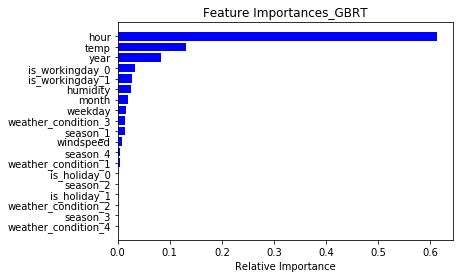

[0.6122890032727647, 0.13108599637925847, 0.08349863148718215, 0.032994789813295955, 0.027116613431870943, 0.025868377995833875, 0.02019588486214152, 0.015788649994934192, 0.014925706605421227, 0.014743648410555905, 0.008267872634683164, 0.004356679495002336, 0.0036970449966711554, 0.0014296539591415838, 0.0012722315713416207, 0.0011919172215257038, 0.0007070023925232658, 0.0005677914971618672, 2.503978690330486e-06]


In [16]:
features = X.columns
importances = GBR.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances_GBRT')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

print(sorted(importances, reverse=True))

The feature importances shows that hour, temperature, and year are the most significant factors that affect the counts of total rental bikes.

Also, it is observed that people tend to rent bikes more on weekends or holidays than weekdays.

### 2.2. KNN
Used both for regression and classification, KNN predicts by using feature similarity. 

The decision on number of nearest neighbors is one of the key for appropriate KNN model. 

As I mentioned before, by conducting 5 fold cross validation, I got a number of neighbors as 5 for the computation for feature similarity. 

In [17]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsRegressor()

grid = GridSearchCV(knn, param_grid, cv=5).fit(X,y)
print(grid.fit(X, y))

print('grid best estimator: ', grid.best_estimator_)
print('grid best params : ', grid.best_params_)
# knn_model = GridSearchCV(knn, param_grid = param_grid, cv = 5).fit(X,y)
# print(knn_model.best_params_)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
grid best estimator:  KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
grid best para

In [18]:
# Function to print the MSE
from sklearn.metrics import mean_squared_error 
# def print_score(m : KNeighborsRegressor):
#     res = ['mse train: ', mean_squared_error(m.predict(X), y),
#            'mse test: ', mean_squared_error(m.predict(X_test), y_test)]
#     if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#     print(res)
KNN = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
 
KNN.fit(X,y)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('RMSE train: ', np.sqrt(mean_squared_error(y,KNN.predict(X))))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test,KNN.predict(X_test))))
print('MAPE train: ', mean_absolute_percentage_error(y,KNN.predict(X)))
print('MAPE test: ', mean_absolute_percentage_error(y_test,KNN.predict(X_test) ))
      

RMSE train:  48.26662869883808
RMSE test:  56.90128013374765
MAPE train:  34.37338747126002
MAPE test:  44.07487971070515


In [19]:
from sklearn.metrics import mean_absolute_error

print('MAE train: ', mean_absolute_error(KNN.predict(X),y))
print('MAE test: ', mean_absolute_error(KNN.predict(X_test), y_test))

MAE train:  30.209617755856968
MAE test:  35.81392405063291


The prediction result shows RMSE training of 48.27, RMSE test of 56.90, MAE train of 30.21, and MAE test of 35.81.

Text(0, 0.5, 'Root Mean Sqaured Error')

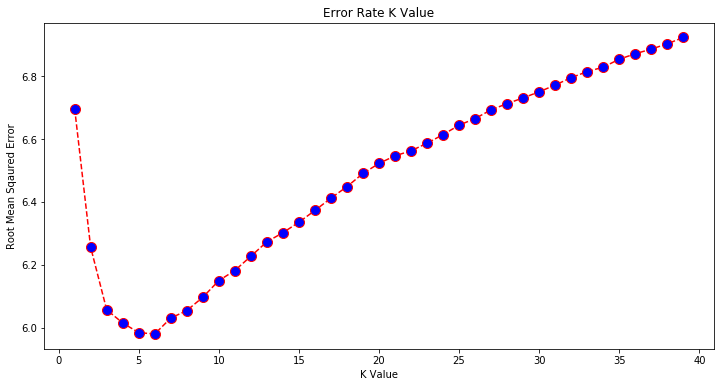

In [20]:
error = []

# Calculating error for K values between 1 and 20
for i in range(1, 40):
    knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=i, p=2,
                    weights='uniform')
    knn.fit(X, y)
    pred_i = knn.predict(X_test)
    error.append(np.sqrt(mean_absolute_error(knn.predict(X_test),y_test)))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Root Mean Sqaured Error')

The figure15 shows that the MSE for the model significantly decreases as it approaches n = 5, and increases as the K value increases. 

K value of 6 might look like a good choice, but it is advisable to choose an odd number over an even number to avoid ties. The points in the each neighborhood are weighted equally.

### 2.3. Decision Tree

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


dtm = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X_train,y_train)
print("R-Squared on train dataset={}".format(dtm.score(X_test,y_test)))

dtm.fit(X_test,y_test)   
print("R-Squaredon test dataset={}".format(dtm.score(X_test,y_test)))

R-Squared on train dataset=0.5629224427653722
R-Squaredon test dataset=0.5668080855181548


**Conduct 5 fold cross validation:**

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=4,
                                             max_features=None,
                                             max_leaf_nodes=10,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': [2, 6, 8],
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                      

**Get the best parameter:** 

In [10]:
print('grid best estimator: ', grid_cv_dtm.best_estimator_)
print('grid best params : ', grid_cv_dtm.best_params_)

grid best estimator:  DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=100, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
grid best params :  {'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [8]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

dtm2 = DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=100, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
 
dtm2.fit(X_train,y_train)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('RMSE train: ', np.sqrt(mean_squared_error(y_train,dtm2.predict(X_train))))
print('RMSE test: ', np.sqrt(mean_squared_error(y_test,dtm2.predict(X_test))))
print('MAE train: ', mean_absolute_error(dtm2.predict(X_train),y_train))
print('MAE test: ', mean_absolute_error(dtm2.predict(X_test), y_test))

RMSE train:  73.10345316944424
RMSE test:  75.72437239258
MAE train:  46.73532400709542
MAE test:  48.6168931152523


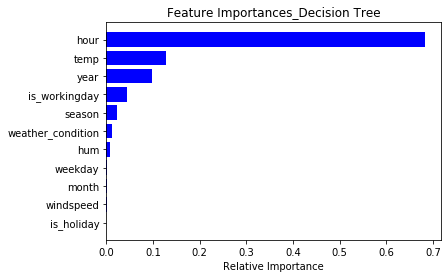

[0.682896687977295, 0.12787432325666961, 0.09804046214308382, 0.045087063701910346, 0.022836882261827313, 0.011221118360680715, 0.006986639908057534, 0.0023533431657689926, 0.001581744805414284, 0.001121734419292355, 0.0]


In [43]:
features = X_train.columns
importances = dtm2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances_Decision Tree')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

print(sorted(importances, reverse=True))

## 3. Result: 

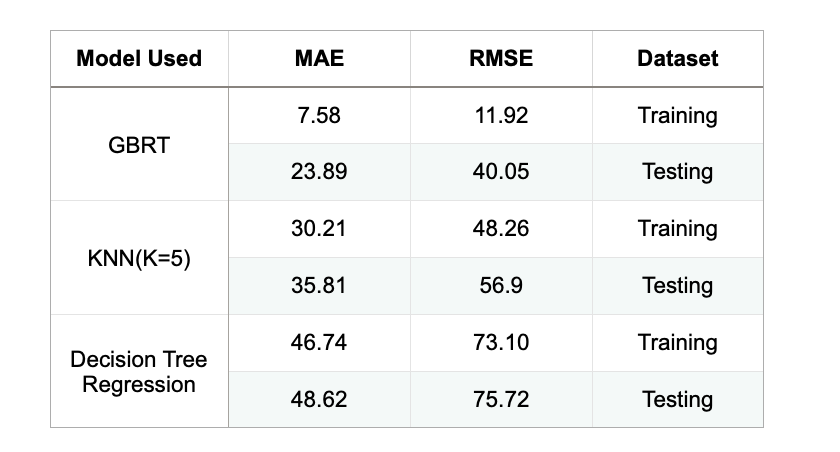

In [1]:
from IPython.display import Image 
Image("result.png")

GBRT has the lowest MAE and RMSE. Still, the difference between training and testing is quite big.

For feature importance, features such as hour, temperature, and year has the highest impact on the demand for bikes

## **References**: 

Mark Kaghazgarian (2018). “Bike Sharing in Washington D.C. Dataset”, ​Kaggle.com.​ Link: ​https://www.kaggle.com/marklvl/bike-sharing-dataset

Timothy Hamilton (2015). ​Bicycle Infrastructure and Traffic Congestion: Evidence from DC's Capital Bikeshare
Link: ​https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2649978

Sathishkumar V E & Yongyun Cho (2019). A rule-based model for Seoul Bike sharing demand prediction using weather data.
Link: ​https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1725789

Mitchell, Paul Philip​ (2018). Predicting Bike-Sharing Traffic Flow using Machine Learning Link:​ ​https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/2564788?locale-attribute=en